In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import root_scalar

import aadc

# Simple Chained Root Scalar Example

This example demonstrates using two sequential root_scalar calls, where the
second call depends on the result of the first call.

## 1. Using SciPy's root_scalar

In [2]:
# Define our first objective function
def objective1(x, target=10.0):
    """Find where x^2 + 5 = target"""
    return x**2 + 5 - target

# Solve for x where x^2 + 5 = 10
result1 = root_scalar(objective1, x0=2.0, method='newton')
x1 = result1.root

print(f"First root (x₁): {x1:.6f}")
print(f"Verification: {x1}² + 5 = {x1**2 + 5:.6f}")

# Define our second objective function, which depends on the first result
def objective2(x, prev_result=x1):
    """Find where x*prev_result - x^3 = 20"""
    return x*prev_result - x**3 - 20

# Solve for x where x*x1 - x^3 = 20
result2 = root_scalar(objective2, x0=2.0, method='newton')
x2 = result2.root

print(f"Second root (x₂): {x2:.6f}")
print(f"Verification: {x2}*{x1} - {x2}³ = {x2*x1 - x2**3:.6f}")

First root (x₁): 2.236068
Verification: 2.2360679774997894² + 5 = 10.000000
Second root (x₂): -2.988166
Verification: -2.9881660639201377*2.2360679774997894 - -2.9881660639201377³ = 20.000000


## 2. Using AADC's root_scalar with automatic differentiation

In [3]:
# Create an AADC kernel for recording the computation
func = aadc.Kernel()
func.start_recording()

# Create an AADC input variable for the target value
target = aadc.idouble(10.0)
target_arg = target.mark_as_input()

# Define the first objective function
def aadc_objective1(x):
    """Find where x^2 + 5 = target"""
    return x**2 + 5 - target

# Solve using AADC root_scalar
aadc_result1 = aadc.root_scalar(aadc_objective1, x0=2.0)
print(f"First AADC root: ~{aadc_result1}")

# Define the second objective function using the first result
def aadc_objective2(x):
    """Find where x*result1 - x^3 = 20"""
    return x*aadc_result1 - x**3 - 20

# Solve the second equation
aadc_result2 = aadc.root_scalar(aadc_objective2, x0=2.0)
print(f"Second AADC root: ~{aadc_result2}")

# Mark the results as outputs for later analysis
result1_out = aadc_result1.mark_as_output()
result2_out = aadc_result2.mark_as_output()

# Stop recording
func.stop_recording()

First AADC root: ~idouble([AAD[rv] [adj] :8,2.24e+00])
Second AADC root: ~idouble([AAD[rv] [adj] :10,-2.99e+00])


## 3. Analysis of dependencies and sensitivities

In [4]:
# Set up inputs and requests for AADC evaluation
inputs = {target_arg: 10.0}
request = {
    result1_out: [target_arg],
    result2_out: [target_arg]
}

# Evaluate the kernel
res = aadc.evaluate(func, request, inputs)

# Extract results
aadc_x1 = res[0][result1_out]
aadc_x2 = res[0][result2_out]

# Extract sensitivities
sensitivity_x1_to_target = res[1][result1_out][target_arg][0]
sensitivity_x2_to_target = res[1][result2_out][target_arg][0]

print("\nAADC Results:")
print(f"First root (x₁): {aadc_x1}")
print(f"Second root (x₂): {aadc_x2}")

print("\nComparison with SciPy results:")
print(f"First root error: {abs(aadc_x1 - x1)}")
print(f"Second root error: {abs(aadc_x2 - x2)}")

print("\nSensitivity Analysis:")
print(f"∂x₁/∂target = {sensitivity_x1_to_target}")
print(f"∂x₂/∂target = {sensitivity_x2_to_target}")


AADC Results:
First root (x₁): [2.23606798]
Second root (x₂): [-2.98816607]

Comparison with SciPy results:
First root error: [4.16014778e-10]
Second root error: [9.11715192e-09]

Sensitivity Analysis:
∂x₁/∂target = 0.22360679770837752
∂x₂/∂target = -0.027215386484702172


## 4. Verification with finite differences

In [5]:
# Function to compute both roots for a given target
def compute_roots(target_val):
    # First root: x^2 + 5 = target
    def obj1(x):
        return x**2 + 5 - target_val

    res1 = root_scalar(obj1, x0=2.0, method='newton')
    x1_val = res1.root

    # Second root: x*x1 - x^3 = 20
    def obj2(x):
        return x*x1_val - x**3 - 20

    res2 = root_scalar(obj2, x0=2.0, method='newton')
    x2_val = res2.root

    return x1_val, x2_val

# Compute finite difference approximations
epsilon = 1e-6
target_base = 10.0
x1_base, x2_base = compute_roots(target_base)
x1_bumped, x2_bumped = compute_roots(target_base + epsilon)

fd_sensitivity_x1 = (x1_bumped - x1_base) / epsilon
fd_sensitivity_x2 = (x2_bumped - x2_base) / epsilon

print("\nFinite Difference Verification:")
print(f"∂x₁/∂target (FD) = {fd_sensitivity_x1}")
print(f"∂x₂/∂target (FD) = {fd_sensitivity_x2}")

print("\nSensitivity Comparison:")
print(f"First root sensitivity error: {abs(sensitivity_x1_to_target - fd_sensitivity_x1)}")
print(f"Second root sensitivity error: {abs(sensitivity_x2_to_target - fd_sensitivity_x2)}")


Finite Difference Verification:
∂x₁/∂target (FD) = 0.22360678686439428
∂x₂/∂target (FD) = -0.027215385500767297

Sensitivity Comparison:
First root sensitivity error: 1.0843983239139376e-08
Second root sensitivity error: 9.839348745488419e-10


## 5. Visualizing the relationship

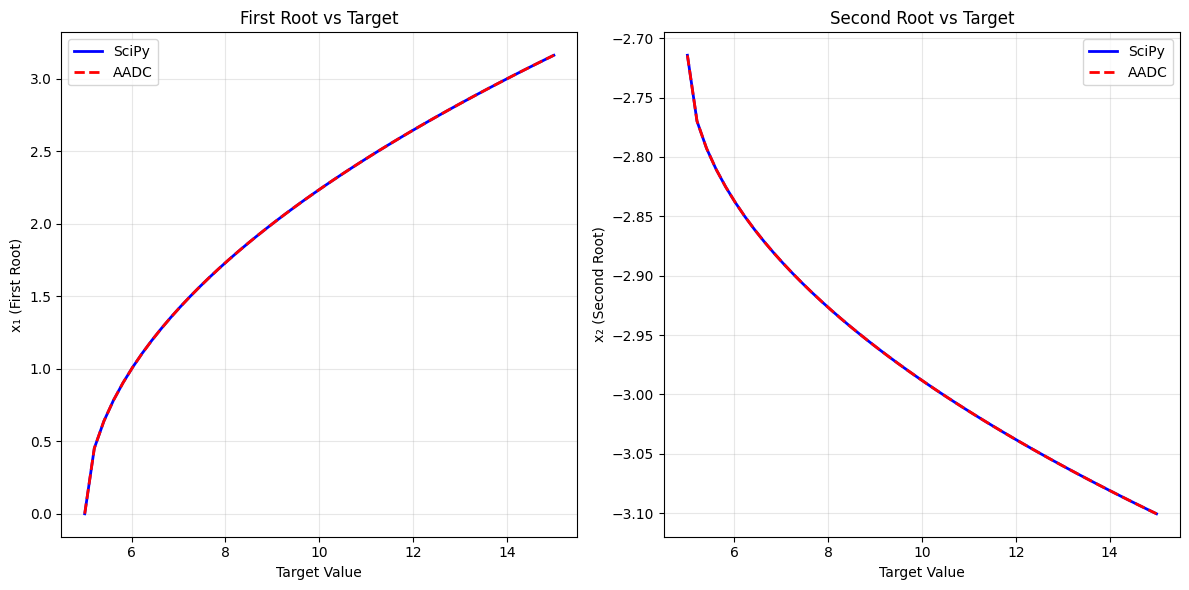

In [6]:
# Compute roots for a range of target values
target_values = np.linspace(5.0, 15.0, 50)
x1_values = []
x2_values = []

for t in target_values:
    x1, x2 = compute_roots(t)
    x1_values.append(x1)
    x2_values.append(x2)

# Plot the relationships
plt.figure(figsize=(12, 6))

# Compute AADC results for the same range of target values as SciPy
aadc_targets = np.linspace(5.0, 15.0, 50)

# Evaluate AADC kernel for all targets at once
inputs = {target_arg: aadc_targets}
res_all_targets = aadc.evaluate(func, request, inputs)

# Extract results for all target values
aadc_x1_values = res_all_targets[0][result1_out]
aadc_x2_values = res_all_targets[0][result2_out]

plt.subplot(1, 2, 1)
plt.plot(target_values, x1_values, 'b-', linewidth=2, label='SciPy')
plt.plot(aadc_targets, aadc_x1_values, 'r--', linewidth=2, label='AADC')
plt.xlabel('Target Value')
plt.ylabel('x₁ (First Root)')
plt.title('First Root vs Target')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(target_values, x2_values, 'b-', linewidth=2, label='SciPy')
plt.plot(aadc_targets, aadc_x2_values, 'r--', linewidth=2, label='AADC')
plt.xlabel('Target Value')
plt.ylabel('x₂ (Second Root)')
plt.title('Second Root vs Target')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Key Insights

1. **Chained Calculations**: The second root_scalar call depends directly on the result of the first call,
   creating a chain of calculations.

2. **Hidden Parameters**: The objective function `objective2` has a hidden dependency on the result of
   the first calculation (`x1`). AADC automatically tracks this dependency.

3. **Sensitivities**: We can compute how changes in the initial target value affect both the first and
   second roots, even though the dependency chain is complex.

4. **Verification**: The sensitivities computed by AADC match those computed using finite differences,
   confirming that AADC correctly tracks dependencies through multiple root_scalar calls.


# Automatic Implicit Function Theorem - Summary

## Paper Details
- **Title**: Automatic Implicit Function Theorem
- **Authors**: Dmitri Goloubentsev, Evgeny Lakshtanov, Vladimir Piterbarg
- **Affiliation**: Matlogica, Universidade de Aveiro, NatWest Markets, Imperial College London
- **Published**: December 14, 2021 (Revised: May 31, 2022)
- **SSRN ID**: 3984964
- **URL**: [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984964](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3984964)